# Fanal, a neutrino-less beta decay experiment 

## An open exercise

### Background estimation 


#### USC, Master de Física, Física de Partículas II


J. A. Hernando-Morata

February 2021 - February 2022

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Importing modules

In [9]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats     as stats  # statistics and Many PDFs 
#import scipy.optimize  as optimize # Minimice funtions

import warnings
warnings.filterwarnings('ignore')

In [10]:
# REMEMBER TO ADD Your Fanal FOLDER TO PYTHONPATH
import os
import sys
import importlib
rootpath = os.getcwd()[:-9]
print('add path to PYTHONPATH : ', rootpath)
sys.path.insert(0, os.path.abspath(rootpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2


In [11]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import ana.pltfanal as pltfn    # plotting for fanal
import     collpars as collpars # collaboration specific parameters
pltext.style()

## Indications

### Objective

  * **Estimate the background contamination**, the number of Bi and Tl events, using blind-data.

### Tasks


   * Open the data file (HDF) and access the mock calibration blind-data.
   
   * Estimate the number of Bi, Tl events in your **blind-data** sample.
   
     * **Fit the energy distribution** to a combination of **energy distributions of Bi and Tl obtained from MC**.
              
   * Test that the data-blind distributions are as expected according to MC. 
   
   * **Estimate the background index** in your RoI

## Notes


 * About Blind Analysis:

   * A **blind analysis** is an analysis in which the data in a region of interest is blind or masked during the analysis. 

   * The analysis must be first completely defined, the procedures and methods verified, before analyzing the complete data set. 

   * A blind-analysis tries to avoid a human bias. To avoid false discoveries.
   
   * Blind data are those events in which the energy of the most energetic track, *track0_E*, is outside the Energy RoI or the less energetic blob of that track, *blob2_E*, is bellow a certain value (*eblob2*).

  * About the estimation of the number of background events

     * Estimate the number of background events using a blind-data set.

     * Compute the mc efficiencies of the blind selection.
     
     * Construct a composite pdf with the energy, *E*, distributions of the blind mc samples.
     
     * Fit the energy, *E*, distribution of the blind data to the composite pdf and estimate the number of bkg event in the blind sample.
     
     * Recover the total number of bkg events.
     
     * Using the selection efficiences, compute the number of bkg events expected in the RoI and in the Energy, *erange*, regions.



### About the fit: Extended likelihood fit

We generate the pdf of a variable (energy) for each mc sample, and define later a combined pdf, $f(x | {\bf n})$ with parameters are ${\bf n} = (n_{bb}, n_{Bi}, n_{Tl})$ the number of events in each sample. 

$$
f(x | {\bf n}) = \sum_i \frac{n_i}{n} \, f_i(x)
$$

where $i$ is the index of each sample, $(\beta\beta0\nu,\, \mathrm{Bi}, \, \mathrm{Tl})$;  $f_i(x)$ the pdf of sample $i$ and $n = \sum_i n_i$

We then compute the likelihood of our sample, $\mathcal{L}({\bf x} | {\bf n}) = \Pi_{i=1}^m f(x_i | {\bf n})$ 
and minimize $- 2 \log \mathcal{L}({\bf x} | {\bf n})$.



An Extended Likelihood includes also the factor of the probability of observing $m$ events expecting $n$.

The total likelihood is:

$$
\mathcal{L}_{ext}({\bf x} | {\bf n}) = g(m | n) \; \Pi_{i=1}^m f(x_i | {\bf n})
$$

where $g(m|n)$ is the poisson pdf with mean $n$.

### Notes

  * Generate the MC pdfs for the different samples and construct the combined PDF. 

  * You can create a pdf from a histogram (see [scipy stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_histogram.html)). 

  * In this guide there is an example of an Extended Maximum Likelihood method.

## Main Parameters

In [12]:
coll          = collpars.collaboration
ntracks_range = collpars.ntracks_range
eblob2_range  = collpars.eblob2_range
erange        = collpars.erange
eroi          = collpars.eroi

print('Collaboration             : {:s}'.format(coll))
print('number of tracks range    : ({:d}, {:6.2f})'.format(*ntracks_range))
print('Blob-2 energy range       : ({:6.3f}, {:6.3f}) MeV'.format(*eblob2_range))
print('Energy range              : ({:6.3f}, {:6.3f}) MeV'.format(*erange))
print('Energy RoI range          : ({:6.3f}, {:6.3f}) MeV'.format(*eroi))

Collaboration             : new_alpha
number of tracks range    : (1,   1.10)
Blob-2 energy range       : ( 0.400,  1.200) MeV
Energy range              : ( 2.400,  2.700) MeV
Energy RoI range          : ( 2.430,  2.480) MeV


## Access the data

In [13]:
#dirpath = '/Users/hernando/docencia/master/Fisica_Particulas/USC-Fanal/data/'
filename = '/data/fanal_' + coll + '.h5'
print('Data path and filename : ', rootpath + filename)

mcbi       = pd.read_hdf(rootpath + filename, key = 'mc/bi214')   # MC Bi
mctl       = pd.read_hdf(rootpath + filename, key = 'mc/tl208')   # MC Tl
data_blind = pd.read_hdf(rootpath + filename, key = 'data/blind') # blind data

mcs      = [mcbi, mctl]
tsamples = ['Bi', 'Tl']
ssamples = [r'$^{214}$Bi', r'$^{208}$Tl']

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2/data/fanal_new_alpha.h5


## Select MC blind samples

In [14]:
# apply the blind selection to the mc samples to obtaine blind mc samples
sels_blind = [fn.selection_blind(mc) for mc in mcs]
mcs_blind  = [mc[sel] for mc, sel in zip(mcs, sels_blind)]

# compute the efficiency of the blid selection on the mc samples
effs_blind = [ut.efficiency(sel)[0] for sel in sels_blind]

for i, mc in enumerate(mcs):
    print('number of events {:s}     : {:d} total, {:d} blind '.format(tsamples[i], 
                                                                       len(mcs[i]), len(mcs_blind[i])))
print('Efficiency blind selection : ', *['{:s} = {:6.4f}, '.format(s, eff) \
                                      for s, eff in zip(tsamples, effs_blind)])

number of events Bi     : 60184 total, 53758 blind 
number of events Tl     : 687297 total, 674815 blind 
Efficiency blind selection :  Bi = 0.8932,  Tl = 0.9818, 


## Energy distribution of the blind-data and blind MC samples


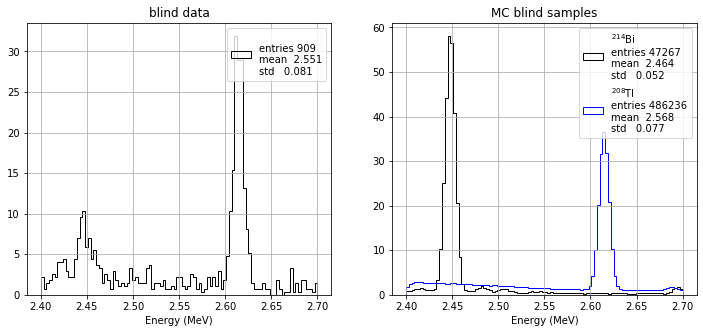

In [15]:
def plot_energy(df, label = '', bins = 100):
    pltext.hist(df.E, bins, range = erange, label = label, density = True)
    plt.xlabel('Energy (MeV)'); 

subplot = pltext.canvas(2)
subplot(1)
plot_energy(data_blind)
plt.title('blind data');

subplot(2)
for i, df in enumerate(mcs_blind):
    plot_energy(df, label = ssamples[i])
plt.legend(); plt.title('MC blind samples');

## Estimate the number of background events in the blind-data

Estimate the number of events of Bi and Tl:  
  
  * Obtain the pdfs distribution for a reference variable, i.e. energy, for each blind sample.

  * Generate a combined pdf where the parameters are the number of events of each sample.

  * Estimate the number of blind Tl and Bi events fitting the energy distribution to the combined pdf.

  * Compute the total number of Tl and Bi using the efficiencies of the blind selection in the MC samples.
  
Note:

  * There is an appendix in the NB to show the code step by step

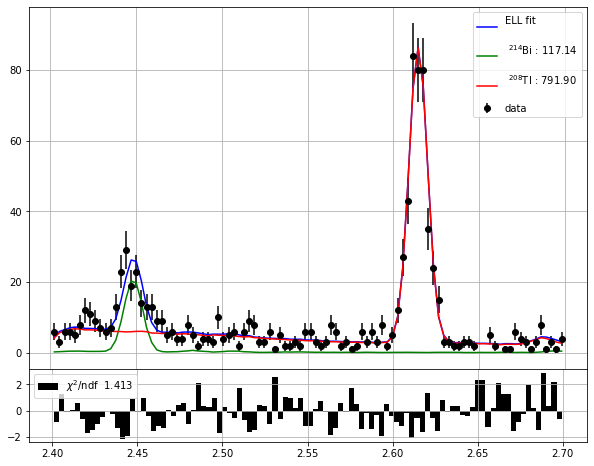

In [16]:
nguess = (1000., 1000.)

varname   = 'E'
refnames  = (varname,) 
refranges = (erange,)

fit        = fn.prepare_fit_ell(mcs_blind, nguess, refnames, refranges)

result, enes, ell, _ = fit(data_blind)
nevts_blind  = result.x

pltfn.plot_fit_ell(enes, nevts_blind, ell, parnames = ssamples);

## Compute the total number of background events

In order to estimate the total number of bkg events in data we need to consider:

  1. The efficiency of the blind selection in each mc sample.
  
  2. The efficiency of the cut in the energy range, *erange* (the range of the fit), on each mc blind sample.
  
  3. The number of estimated events.

In [17]:
effs_ene   = [ut.selection_efficiency(mc, 'E', erange)[0]  for mc in mcs_blind]
effs_total = np.array(effs_ene) * np.array(effs_blind)

print(' blind     efficiency :', *['{:s} = {:6.4f}'.format(s, eff) for s, eff in zip(tsamples, effs_blind)])
print(' E range   efficiency :', *['{:s} = {:6.4f}'.format(s, eff) for s, eff in zip(tsamples, effs_ene)])
print(' blind & E efficiency :', *['{:s} = {:6.4f}'.format(s, eff) for s, eff in zip(tsamples, effs_total)])

 blind     efficiency : Bi = 0.8932 Tl = 0.9818
 E range   efficiency : Bi = 0.8793 Tl = 0.7205
 blind & E efficiency : Bi = 0.7854 Tl = 0.7075


In [18]:
nevts = [ni / eff for ni, eff in zip(nevts_blind, effs_total)]

print(' Events in blind & E  :', *['{:s} = {:6.2f}'.format(s, ni) for s, ni in zip(tsamples, nevts_blind)])
print(' Total Bkg Events     :', *['{:s} = {:6.2f}'.format(s, ni) for s, ni in zip(tsamples, nevts)])

 Events in blind & E  : Bi = 117.14 Tl = 791.90
 Total Bkg Events     : Bi = 149.15 Tl = 1119.36


## Calculate the number of background events in RoI 

  * We use the selection efficiencies to compute the number of events in the RoI, *eroi*, and energy range, *erange*, regions


In [19]:
effs_e    = (collpars.eff_Bi_E  , collpars.eff_Tl_E)             # selection efficiency in the erange
effs_roi  = (collpars.eff_Bi_RoI, collpars.eff_Tl_RoI)           # selection efficiency in the eroi

nenes     = [nevt * eff for nevt, eff in zip(nevts, effs_e)]     # Estimated numbers of events in erange
nrois     = [nevt * eff for nevt, eff in zip(nevts, effs_roi)]   # Estimated numbers of events in RoI

for i, eff in enumerate(effs_e):
    print('Sample {:s}: efficiency in E Range  = {:1.2e}, events in E range = {:6.2f}'.format(tsamples[i], eff, nenes[i]))
for i, eff in enumerate(effs_roi):
    print('Sample {:s}: efficiency in RoI      = {:1.2e}, events in RoI     = {:6.2f}'.format(tsamples[i], eff, nrois[i]))

Sample Bi: efficiency in E Range  = 1.80e-02, events in E range =   2.68
Sample Tl: efficiency in E Range  = 7.30e-03, events in E range =   8.17
Sample Bi: efficiency in RoI      = 1.55e-02, events in RoI     =   2.31
Sample Tl: efficiency in RoI      = 1.94e-04, events in RoI     =   0.22


## Calculate the background index in the RoI 

The **background index** in the number of events expected in the RoI region per keV and exposure (kg y). 

The units os bkg-index are: *counts/ (keV kg y)*

The *exposure* if the *kg y* of data collected by an experiment. 

For example a 100 kg detector operating 5 years, has an exposure of 500 kg y.

Every collaboration has a different exposure! **Ask for it!**

In [20]:
exposures  = {'new_alpha': 500, 'new_beta': 1000, 'new_gamma': 1000,
              'new_delta': 3000, 'new_epsilon': 3000}
acc_bb     = 0.79
exposure   = exposures[coll]
roi_size   = 1e3 * (eroi[1] - eroi[0]) # keV
bkg_index  = np.sum(nrois)/(roi_size * exposure) # counts/ (keV kg y)

print('RoI               : ', eroi, ' MeV.')
print('RoI size          : {:6.3} keV.'.format(roi_size))
print('Bkg events in RoI : ', *['{:s} \t {:6.2f},'.format(s, ni) for s, ni in zip(tsamples, nrois)])
print('Exposure          : ', exposure, ' kg y.')
print('Bkg index in RoI  : {:1.2e} counts/(kg keV y).'.format(bkg_index))

RoI               :  (2.43, 2.48)  MeV.
RoI size          :   50.0 keV.
Bkg events in RoI :  Bi 	   2.31, Tl 	   0.22,
Exposure          :  500  kg y.
Bkg index in RoI  : 1.01e-04 counts/(kg keV y).


## Write out

In [21]:
write = True
if (write):
    of = open('collpars.py', 'a')
    of.write('exposure        = {:6.2f}'.format(exposure)+' # kg y \n')
    of.write('bkg_index       = {:1.3e}'.format(bkg_index)+' # counts /(keV kg y) \n')
    of.write('roi_size        = {:6.3f}'.format(roi_size)+' # keV \n') 
    of.write('acc_bb          = {:6.3f}'.format(acc_bb)+'\n')
    for i, sample in enumerate(tsamples):
        of.write('eff_'+sample+'_blind    = {:6.3f}'.format(effs_total[i])+'\n')
        of.write('nevts_'+sample+'_blind  = {:6.3f}'.format(nevts_blind[i])+'\n')
        of.write('nevts_'+sample+'        = {:6.3f}'.format(nevts[i])+'\n')
        of.write('nevts_'+sample+'_E      = {:6.3f}'.format(nenes[i])+'\n')
        of.write('nevts_'+sample+'_RoI    = {:6.3f}'.format(nrois[i])+'\n')
    of.close()

## Apendix: step by step 

In [22]:
# select the variable and range to generate the pdfs
bins     = 200
varname  = 'E' 
varrange = erange

# generate the PDFs using the blind mc samples
histos   = [np.histogram(mc[varname], bins, range = varrange) for mc    in mcs_blind]
pdfs     = [stats.rv_histogram(histo)                         for histo in histos]

# generate the extended combined pdf ibject 
nguess   = (1000, 2000) # initial guess of the number of events of each sample
ell      = efit.ExtComPDF(pdfs, *nguess)

# get the energy values of the blind data in the energy range
sel      = ut.selection(data_blind, varname, varrange)
enes     = data_blind[varname][sel]

# fit the energy values to the combined pdf using an unbinned extended likelihood fit
res      = ell.best_estimate(enes, *nguess)
nbest    = res.x

# access the information of the 'res' Result Object (see )
print('Fit success? {:s},\nEstimated parameters: {:6.2f}, {:6.2f}'.format(str(res.success), *nbest))

Fit success? True,
Estimated parameters: 117.54, 791.43


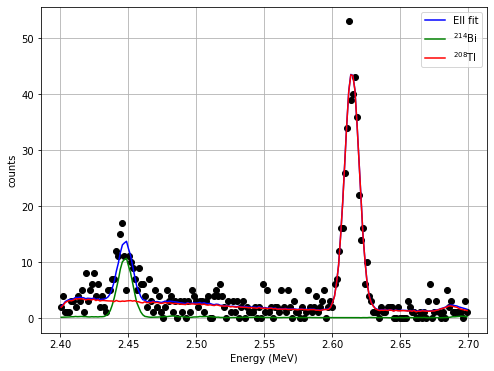

In [23]:
# Plot the data
pltext.canvas(1, 1, 6, 8)

counts, xbins = np.histogram(enes, bins, range = erange)
xcenters      = 0.5 * (xbins[1:] + xbins[:-1])
plt.plot(xcenters, counts, marker = 'o', ls = '');

# plot the pdfs scaled by the number of events
ntot = np.sum(nbest)
dx   = xbins[1] - xbins[0]
plt.plot(xcenters, ntot * dx * ell.pdf(xcenters, *nbest), label = 'Ell fit');
for i, pdf in enumerate(pdfs):
    plt.plot(xcenters, nbest[i] * dx * pdf.pdf(xcenters), label = ssamples[i]);
plt.grid(which='both'); plt.legend();
plt.xlabel('Energy (MeV)'); plt.ylabel('counts');